# Imports

In [1]:
!pip install mlflow -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.6.1 requires cubinlinker, which is not installed.
cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.6.1 requires ptxcompiler, which is not installed.
cuml 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.3 which is incompatible.
cudf 24.6

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torchvision
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image
import mlflow
import mlflow.pytorch
from tqdm import tqdm
import numpy as np

# Configuration and Preprocessing
## Seed the Environment for Reproducibility

In [3]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

mlflow.set_tracking_uri("file:///kaggle/working/mlruns")

## Load the Data

In [4]:
train_csv = '/kaggle/input/aerial-images-of-palm-trees/Palm-Counting-349images/train_labels.csv'
test_csv = '/kaggle/input/aerial-images-of-palm-trees/Palm-Counting-349images/test_labels.csv'
train_img_dir = '/kaggle/input/aerial-images-of-palm-trees/Palm-Counting-349images/train'
test_img_dir = '/kaggle/input/aerial-images-of-palm-trees/Palm-Counting-349images/test'
img_target_size = 320

## Load the CSV data

In [5]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [6]:
print("Training Data:")
train_df.head()

Training Data:


,filename,width,height,class,xmin,ymin,xmax,ymax
0,ck2oh0xx2sthb0838g3pmr4ky.jpg,4000,3000,Palm,1147,1694,1337,1863
1,ck2oh0xx2sthb0838g3pmr4ky.jpg,4000,3000,Palm,1392,1725,1567,1918
2,ck2oh0xx2sthb0838g3pmr4ky.jpg,4000,3000,Palm,1645,1816,1756,1933
3,ck2oh0xx2sthb0838g3pmr4ky.jpg,4000,3000,Palm,1913,1793,2104,1966
4,ck2oh0xx2sthb0838g3pmr4ky.jpg,4000,3000,Palm,2270,1817,2488,2034


In [7]:
print("Missing values in training data:")
train_df.isnull().sum()

Missing values in training data:


filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [8]:
print("Data description:")
train_df.describe()


Data description:


,width,height,xmin,ymin,xmax,ymax
count,10398.000000,10398.000000,10398.000000,10398.000000,10398.000000,10398.000000
mean,4534.887478,3288.108482,1994.680515,1446.275341,2373.671764,1805.706193
std,408.551641,508.586710,1286.072644,963.780248,1296.615612,975.751856
min,4000.000000,2160.000000,0.000000,0.000000,59.000000,38.000000
25%,4000.000000,3000.000000,894.250000,617.250000,1265.250000,974.000000
50%,4864.000000,3648.000000,1901.500000,1410.500000,2272.000000,1759.000000
75%,4864.000000,3648.000000,3024.750000,2219.750000,3431.750000,2583.000000
max,4864.000000,3648.000000,4793.000000,3553.000000,4864.000000,3648.000000


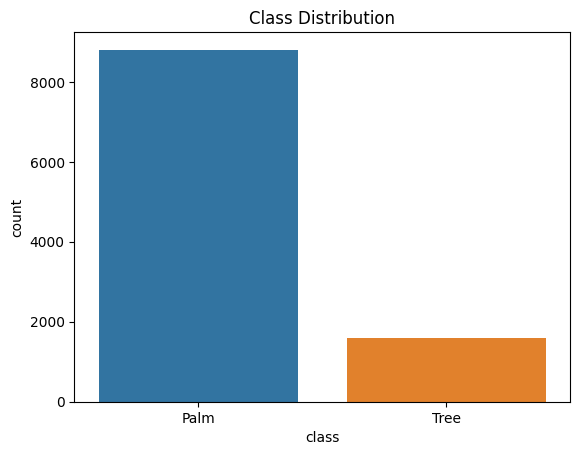

In [9]:
sns.countplot(data=train_df, x='class')
plt.title("Class Distribution")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


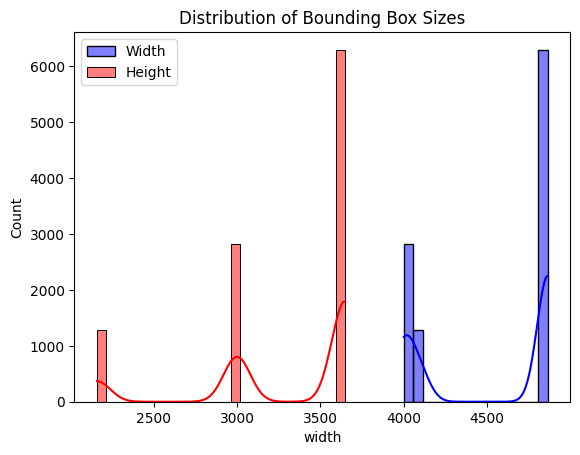

In [10]:
sns.histplot(train_df['width'], kde=True, color='blue', label='Width')
sns.histplot(train_df['height'], kde=True, color='red', label='Height')
plt.title("Distribution of Bounding Box Sizes")
plt.legend()
plt.show()

In [11]:
# Filter the DataFrame to include only rows where the class is 'Palm'
palm_df = test_df[test_df['class'] == 'Palm']

# Group by filename and count occurrences
unique_image_counts = palm_df.groupby('filename').size().reset_index(name='count')
unique_image_counts.head()

,filename,count
0,ck2euxc9kxgvm07486g2d5pid.jpg,46
1,ck2g7wdv128xl0811szdwargh.jpg,90
2,ck2g892277awc0725zbo48h3z.jpg,89
3,ck2g8ivqq2flt0811ddim0vch.jpg,78
4,ck2gc6eaggd4m0748e86tcwvm.jpg,69


In [12]:
# ck2jfuaiwocqi07256rg8xca1

In [13]:
palm_df = test_df[test_df['class'] == 'Palm']
unique_image_counts = palm_df.groupby('filename').size().reset_index(name='count')

palm_trees_count = torch.tensor(unique_image_counts[unique_image_counts['filename'] == "ck2jfuaiwocqi07256rg8xca1.jpg"]['count'], dtype=torch.int64)
palm_trees_count

tensor([], dtype=torch.int64)

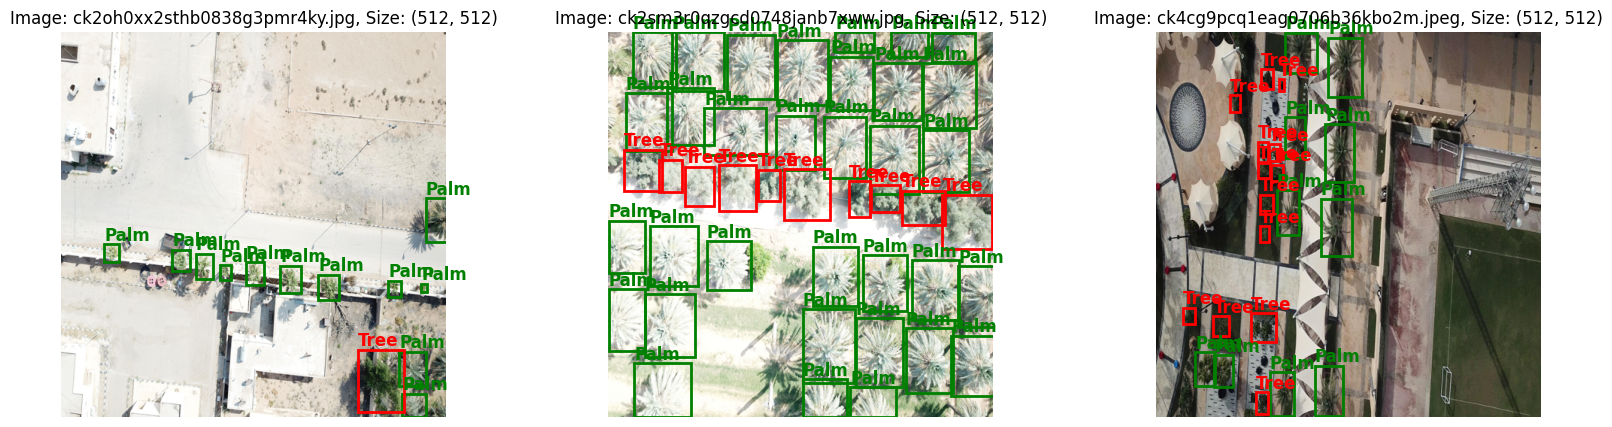

In [14]:
def visualize_sample_images(df, img_dir, num_images=3, img_size=512):
    sample_images = df['filename'].unique()[:num_images]
    fig, ax = plt.subplots(1, num_images, figsize=(20, 5))
    colors = {'Tree': 'red', 'Palm': 'green'}  # Colors for different classes
    
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(img_dir, img_name)
        image = Image.open(img_path)
        
        # Resize image to the specified size (512x512)
        original_width, original_height = image.size
        image = image.resize((img_size, img_size))
        
        ax[i].imshow(image)
        
        img_df = df[df['filename'] == img_name]
        for _, row in img_df.iterrows():
            # Normalize bounding boxes
            xmin = (row['xmin'] / original_width) * img_size
            ymin = (row['ymin'] / original_height) * img_size
            xmax = (row['xmax'] / original_width) * img_size
            ymax = (row['ymax'] / original_height) * img_size
            
            class_label = row['class']
            color = colors[class_label]  # Set color based on class
            ax[i].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor=color, facecolor='none', lw=2))
            ax[i].text(xmin, ymin - 5, class_label, color=color, fontsize=12, weight='bold')  # Add class label
            
        ax[i].set_title(f"Image: {img_name}, Size: {image.size}")
        ax[i].axis('off')
    
    plt.show()

# Call the visualization function
visualize_sample_images(train_df, train_img_dir)


# Model definition

In [15]:
import torchvision.transforms as T

def get_transforms():
    return T.Compose([
        T.ToTensor(),                     
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [16]:
class PalmTreeDataset(Dataset):
    def __init__(self, dataframe, img_dir, transforms=None, train=True, target_size=(img_target_size, img_target_size)):
        self.data = dataframe
        self.img_dir = img_dir
        self.transforms = transforms
        self.target_size = target_size
        self.train = train

        # Create the unique image counts for Palm trees once during initialization
        palm_df = self.data[self.data['class'] == 'Palm']
        self.unique_image_counts = palm_df.groupby('filename').size().reset_index(name='count')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        img = Image.open(img_path).convert("RGB") 
        
        # Resize the image
        img = img.resize(self.target_size, Image.BILINEAR)
        width, height = self.target_size
        
        if self.train:
            # Bounding box normalization
            xmin = (row['xmin'] / row['width']) * width 
            xmax = (row['xmax'] / row['width']) * width
            ymin = (row['ymin'] / row['height']) * height
            ymax = (row['ymax'] / row['height']) * height

            boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
            labels = torch.tensor([1 if row['class'] == 'Palm' else 2], dtype=torch.int64)

            target = {'boxes': boxes, 'labels': labels}

            if self.transforms:
                img = self.transforms(img)

            return img, target
        
        if self.transforms:
            img = self.transforms(img)
        
        # Get the count for the filename
        filename = row['filename']
        palm_trees_count_series = self.unique_image_counts[self.unique_image_counts['filename'] == filename]['count']
        # Extract the count value, default to 0 if not found
        palm_trees_count = torch.tensor(palm_trees_count_series.iloc[0] if not palm_trees_count_series.empty else 0, dtype=torch.int64)
        
        return img, palm_trees_count


In [17]:
def get_data_loaders(train_df, test_df, train_img_dir, test_img_dir, batch_size=32, target_size=(img_target_size, img_target_size)):
    transforms = get_transforms()
    # Load the datasets
    train_dataset = PalmTreeDataset(train_df, train_img_dir, transforms=transforms, target_size=target_size)
    test_dataset = PalmTreeDataset(test_df, test_img_dir, train=False, transforms=transforms, target_size=target_size)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    
    return train_loader, test_loader

In [18]:
def get_fasterrcnn_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

## custom metrics

In [19]:
def count_palm_trees(predictions):
    """ Count the number of palm trees predicted in the images """
    return sum((pred['labels'] == 1).sum().item() for pred in predictions)

def compute_metrics(predictions, targets):
    """ Compute MAE and MSE between predicted and ground truth palm tree counts """
    pred_counts = np.array([count_palm_trees([pred]) for pred in predictions])
    gt_counts = np.array([targ.item() for targ in targets])
    
    mae = np.mean(np.abs(pred_counts - gt_counts))
    rmse = np.sqrt(np.mean((pred_counts - gt_counts) ** 2))
    
    return mae, rmse


In [20]:
def train_model(model, train_loader, test_loader, device, epochs):
    model.to(device)
   
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
#     lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        # Use tqdm for progress bar
        for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())
            train_loss += losses.item()
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
#         lr_scheduler.step()
        avg_train_loss = train_loss / len(train_loader)
        print(f'Epoch {epoch + 1} - Training Loss: {avg_train_loss}')
        
        # Evaluate the model on the test set (used as validation)
        validate_model(model, test_loader, device)
        
        mlflow.log_metrics({'train_loss': avg_train_loss}, step=epoch+1)
    
    return model



In [21]:
def validate_model(model, test_loader, device):
    model.eval()
    val_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for imgs, targets in tqdm(test_loader, desc="Validation", leave=False):
            imgs = [img.to(device) for img in imgs]
            targets = [t.to(device) for t in targets]
            
            # Get the predictions from the model
            predictions = model(imgs)
            all_predictions.extend(predictions)
            all_targets.extend(targets)

    # Compute evaluation metrics
    mae, rmse = compute_metrics(all_predictions, all_targets)
    
    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Squared Error: {rmse}')
    
    mlflow.log_metrics({'mae': mae, 'rmse': rmse})


In [22]:
def main(epochs):
    train_df = pd.read_csv('/kaggle/input/aerial-images-of-palm-trees/Palm-Counting-349images/train_labels.csv')
    test_df = pd.read_csv('/kaggle/input/aerial-images-of-palm-trees/Palm-Counting-349images/test_labels.csv')
    train_img_dir = '/kaggle/input/aerial-images-of-palm-trees/Palm-Counting-349images/train'
    test_img_dir = '/kaggle/input/aerial-images-of-palm-trees/Palm-Counting-349images/test'
    model_path = '/kaggle/working/model_checkpoint.pth'
    batch_size = 8
    img_target_size = 320
    
    train_loader, test_loader = get_data_loaders(train_df, test_df, train_img_dir, test_img_dir, batch_size = batch_size, target_size=(img_target_size, img_target_size))
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    model = get_fasterrcnn_model(num_classes=3)
    
    mlflow.set_experiment('palm_tree_counting')
    
    with mlflow.start_run() as run:
        trained_model = train_model(model, train_loader,test_loader, device, epochs)
        torch.save(trained_model.state_dict(), model_path)
        mlflow.pytorch.log_model(trained_model, "model")
        print(f"Model saved in run {run.info.run_id}")
        
        # Evaluate the model on the test set
        validate_model(trained_model, test_loader, device)

In [23]:
main(2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 150MB/s]
2024/08/13 09:09:09 INFO mlflow.tracking.fluent: Experiment with name 'palm_tree_counting' does not exist. Creating a new experiment.


Epoch 1 - Training Loss: 0.12703150514226694


Mean Absolute Error: 5.831835205992509
Root Mean Squared Error: 8.08320494897853


Epoch 2 - Training Loss: 0.11019426127465871


Mean Absolute Error: 7.6367041198501875
Root Mean Squared Error: 11.24260889125153


2024/08/13 10:49:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Model saved in run 83e9d49f71cf4d29bdb35ce13386dd5e


Mean Absolute Error: 7.6367041198501875
Root Mean Squared Error: 11.24260889125153
